# Задача кластеризации для RFM-анализа 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from mpl_toolkits.mplot3d import Axes3D

import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

## 1. Анализ первичных данных

In [2]:
# Загрузка датасета

retail = pd.read_csv('OnlineRetail.csv', sep=",", encoding="ISO-8859-1", header=0)
retail.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom


In [3]:
retail.shape

(541909, 8)

In [4]:
retail.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [5]:
retail.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


In [6]:
# Процент недостающих значений в датафрейме

df_null = 100 * (retail.isnull().sum()) / len(retail)
df_null

InvoiceNo       0.000000
StockCode       0.000000
Description     0.268311
Quantity        0.000000
InvoiceDate     0.000000
UnitPrice       0.000000
CustomerID     24.926694
Country         0.000000
dtype: float64

In [7]:
# Удаление строк с пропущенными значениями

retail = retail.dropna()
retail.shape

(406829, 8)

In [8]:
retail.min()

InvoiceNo                              536365
StockCode                               10002
Description     4 PURPLE FLOCK DINNER CANDLES
Quantity                               -80995
InvoiceDate                  01-02-2011 08:23
UnitPrice                                   0
CustomerID                              12346
Country                             Australia
dtype: object

In [9]:
# Количество отрицательных и нулевых значений для столбца Quantity

len(retail[retail['Quantity'] <= 0])

8905

In [10]:
# Удаление отрицательных значений и нулевых значений

retail = retail[retail['Quantity'] > 0]
retail.shape

(397924, 8)

In [11]:
retail['CustomerID'] = retail['CustomerID'].astype(str)

## 2. Подготовка данных

 Для RFM-анализа необходимо создать новый набор данных для последующей кластеризации.
- R (Recency) - давность.
- F (Frequency) - частота.
- M (Monetary) - деньги.

In [12]:
# Monetary

retail['Amount'] = retail['Quantity'] * retail['UnitPrice']
rfm_m = retail.groupby('CustomerID')['Amount'].sum()
rfm_m = rfm_m.reset_index()
rfm_m.columns = ['CustomerID', 'Monetary']
rfm_m.head()

,CustomerID,Monetary
0,12346.0,77183.60
1,12347.0,4310.00
2,12348.0,1797.24
3,12349.0,1757.55
4,12350.0,334.40


In [13]:
# Frequency

rfm_f = retail.groupby('CustomerID')['InvoiceNo'].count()
rfm_f = rfm_f.reset_index()
rfm_f.columns = ['CustomerID', 'Frequency']
rfm_f.head()

,CustomerID,Frequency
0,12346.0,1
1,12347.0,182
2,12348.0,31
3,12349.0,73
4,12350.0,17


In [14]:
# Recency

retail['InvoiceDate'] = pd.to_datetime(retail['InvoiceDate'], format='%d-%m-%Y %H:%M')

In [15]:
# Максимальная дата - дата последней транзакции

max_date = max(retail['InvoiceDate'])
max_date

Timestamp('2011-12-09 12:50:00')

In [16]:
# Разница между макстмальной датой и датой транзакции = как давно что-то покупали

retail['Diff'] = max_date - retail['InvoiceDate']
retail.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Amount,Diff
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,373 days 04:24:00
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,373 days 04:24:00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00


In [17]:
# Вычислить дату последней транзакции, чтобы узнать время последней покупки

rfm_r = retail.groupby('CustomerID')['Diff'].min()
rfm_r = rfm_r.reset_index()
rfm_r.head()

,CustomerID,Diff
0,12346.0,325 days 02:49:00
1,12347.0,1 days 20:58:00
2,12348.0,74 days 23:37:00
3,12349.0,18 days 02:59:00
4,12350.0,309 days 20:49:00


In [18]:
# Только количество дней

rfm_r['Diff'] = rfm_r['Diff'].dt.days
rfm_r.head()

,CustomerID,Diff
0,12346.0,325
1,12347.0,1
2,12348.0,74
3,12349.0,18
4,12350.0,309


In [19]:
# Объединение в итоговую таблицу

rfm = pd.merge(rfm_r, rfm_f, on='CustomerID', how='inner')
rfm = pd.merge(rfm, rfm_m, on='CustomerID', how='inner')
rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']
rfm

,CustomerID,Recency,Frequency,Monetary
0,12346.0,325,1,77183.60
1,12347.0,1,182,4310.00
2,12348.0,74,31,1797.24
3,12349.0,18,73,1757.55
4,12350.0,309,17,334.40
...,...,...,...,...
4334,18280.0,277,10,180.60
4335,18281.0,180,7,80.82
4336,18282.0,7,12,178.05
4337,18283.0,3,756,2094.88


In [20]:
rfm.describe()

,Recency,Frequency,Monetary
count,4339.000000,4339.000000,4339.000000
mean,91.518322,91.708689,2053.793018
std,100.009747,228.792852,8988.248381
min,0.000000,1.000000,0.000000
25%,17.000000,17.000000,307.245000
50%,50.000000,41.000000,674.450000
75%,141.000000,100.000000,1661.640000
max,373.000000,7847.000000,280206.020000


#### Исследование на выбросы

Text(0.5, 0, 'Признаки')

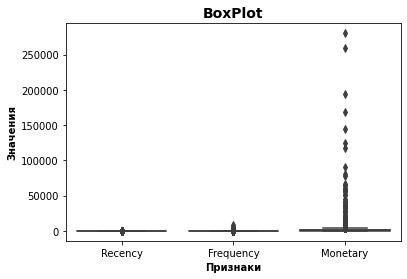

In [21]:
attributes = ['Recency', 'Frequency', 'Monetary']
sns.boxplot(data = rfm[attributes], orient="v")
plt.title("BoxPlot", fontsize = 14, fontweight = 'bold')
plt.ylabel("Значения", fontweight = 'bold')
plt.xlabel("Признаки", fontweight = 'bold')

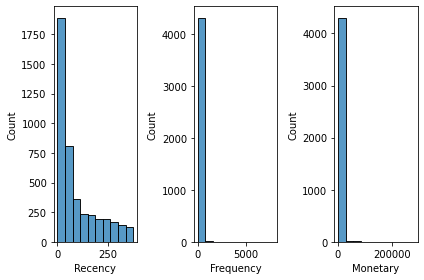

In [22]:
fig, ax = plt.subplots(ncols=3)
sns.histplot(rfm['Recency'], ax=ax[0], bins=10)
sns.histplot(rfm['Frequency'], ax=ax[1], bins=10)
sns.histplot(rfm['Monetary'], ax=ax[2], bins=10)
fig.tight_layout()

In [23]:
# Удаление статистическиз выбросов для каждого признака
Q1 = rfm['Recency'].quantile(0.05)
Q3 = rfm['Recency'].quantile(0.95)
IQR = Q3 - Q1
rfm = rfm[(rfm['Recency'] >= Q1 - 1.5*IQR) & (rfm['Recency'] <= Q3 + 1.5*IQR)]

Q1 = rfm['Frequency'].quantile(0.05)
Q3 = rfm['Frequency'].quantile(0.95)
IQR = Q3 - Q1
rfm = rfm[(rfm['Frequency'] >= Q1 - 1.5*IQR) & (rfm['Frequency'] <= Q3 + 1.5*IQR)]

Q1 = rfm['Monetary'].quantile(0.05)
Q3 = rfm['Monetary'].quantile(0.95)
IQR = Q3 - Q1
rfm = rfm[(rfm['Monetary'] >= Q1 - 1.5*IQR) & (rfm['Monetary'] <= Q3 + 1.5*IQR)]

Text(0.5, 0, 'Признаки')

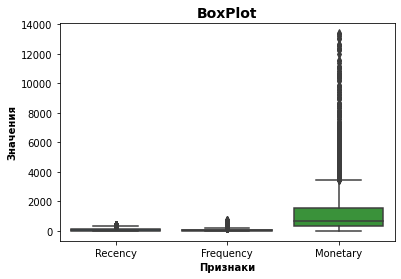

In [24]:
attributes = ['Recency', 'Frequency', 'Monetary']
sns.boxplot(data = rfm[attributes], orient="v")
plt.title("BoxPlot", fontsize = 14, fontweight = 'bold')
plt.ylabel("Значения", fontweight = 'bold')
plt.xlabel("Признаки", fontweight = 'bold')

## 3. Стандартизация данных

In [25]:
# Standard Scaler

rfm_df = rfm[['Recency', 'Frequency', 'Monetary']]
scaler = StandardScaler()
rfm_df_scaled = scaler.fit_transform(rfm_df)
rfm_df_scaled.shape

(4256, 3)

In [26]:
rfm_df_scaled = pd.DataFrame(rfm_df_scaled)
rfm_df_scaled.columns = ['Recency', 'Frequency', 'Monetary']
rfm_df_scaled.head()

,Recency,Frequency,Monetary
0,-0.918050,1.054881,1.686800
1,-0.189471,-0.457886,0.273137
2,-0.748381,-0.037117,0.250808
3,2.155955,-0.598143,-0.549847
4,-0.578711,0.083103,0.671904


## 4. Построение модели

### K-Means Clustering

K-Means Clustering - один из самых простых и популярных алгоритмов кластеризации.

Алгоритм работает следующим образом:

- Сначала мы случайным образом инициализируем k точек.
- Мы классифицируем каждый элемент по ближайшему среднему значению и обновляем координаты среднего значения, которые представляют собой средние значения элементов, отнесенных к этому среднему значению на данный момент.
- Мы повторяем процесс для заданного количества итераций, и в конце получаем группы кластеров.

In [27]:
# K-Means с 4 кластерами

kmeans = KMeans(n_clusters=4, max_iter=50)
kmeans.fit(rfm_df_scaled)

KMeans(max_iter=50, n_clusters=4)

In [28]:
kmeans.labels_

array([3, 0, 0, ..., 0, 1, 0])

### Поиск оптимального количества кластеров

Фундаментальным шагом для любого алгоритма без учителя является определение оптимального количества кластеров, в которые могут быть сгруппированы данные.

#### "Локтевой" метод (Elbow Curve)

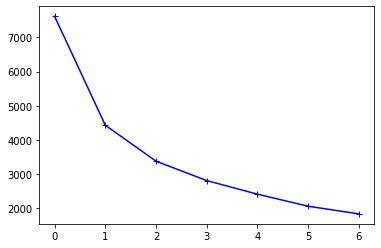

In [29]:
# Elbow-curve/SSD

ssd = []
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(rfm_df_scaled)
    
    ssd.append(kmeans.inertia_)
    
# plot the SSDs for each n_clusters
plt.plot(ssd, 'b+-')

#### Silhouette Analysis

$$\text{silhouette score}=\frac{p-q}{max(p,q)}$$

$p$ - среднее расстояние до точек в ближайшем кластере, в который точка данных не входит.

$q$ - среднее расстояние внутри кластера до всех точек в собственном кластере.

* Значение диапазона оценки находится в диапазоне от -1 до 1.
* Оценка, близкая к 1, означает, что точка очень похожа на другой набор точек в кластере.
* Оценка, близкая к -1, указывает на то, что точка не похожа на набор точек в своем кластере.

In [30]:
# Silhouette analysis
range_n_clusters = range(2, 9)

for num_clusters in range_n_clusters:
    
    # intialise kmeans
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(rfm_df_scaled)
    
    cluster_labels = kmeans.labels_
    
    # silhouette score
    silhouette_avg = silhouette_score(rfm_df_scaled, cluster_labels)
    print("For n_clusters={0}, the silhouette score is {1}".format(num_clusters, silhouette_avg))

For n_clusters=2, the silhouette score is 0.5411560588355119
For n_clusters=3, the silhouette score is 0.5082345035676454
For n_clusters=4, the silhouette score is 0.4765613103345572
For n_clusters=5, the silhouette score is 0.4663859509597792
For n_clusters=6, the silhouette score is 0.4162892716857476
For n_clusters=7, the silhouette score is 0.4132947499363805
For n_clusters=8, the silhouette score is 0.409258413250418


In [31]:
# Окончательный результат при k=3
kmeans = KMeans(n_clusters=3, max_iter=50)
kmeans.fit(rfm_df_scaled)

KMeans(max_iter=50, n_clusters=3)

In [32]:
kmeans.labels_

array([1, 0, 0, ..., 0, 1, 0])

In [33]:
rfm['ClusterID'] = kmeans.labels_
rfm.head()

,CustomerID,Recency,Frequency,Monetary,ClusterID
1,12347.0,1,182,4310.00,1
2,12348.0,74,31,1797.24,0
3,12349.0,18,73,1757.55,0
4,12350.0,309,17,334.40,2
5,12352.0,35,85,2506.04,0


#### Визуализация кластеров (K-Means)

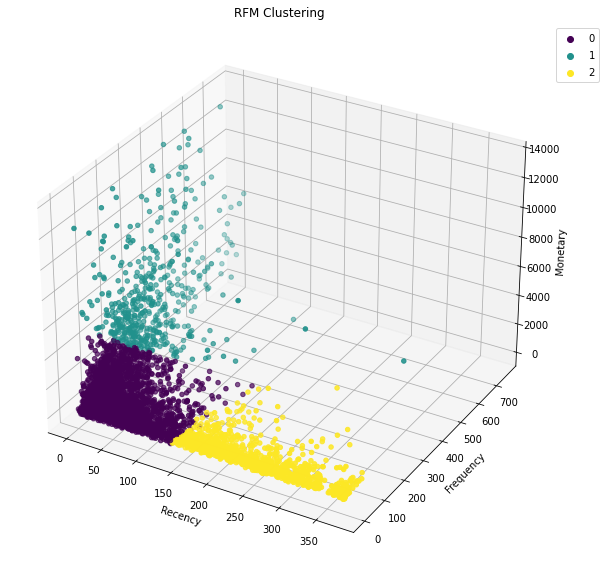

In [34]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(xs=rfm['Recency'], ys=rfm['Frequency'], zs=rfm['Monetary'], c=rfm['ClusterID'])

plt.title('RFM Clustering')
ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')
plt.legend(*sc.legend_elements(), bbox_to_anchor=(1,1), loc=2)

#### C понижением размерности до 2D

In [46]:
rfm_df_scaled.head()

,Recency,Frequency,Monetary
0,-0.918050,1.054881,1.686800
1,-0.189471,-0.457886,0.273137
2,-0.748381,-0.037117,0.250808
3,2.155955,-0.598143,-0.549847
4,-0.578711,0.083103,0.671904


In [47]:
pca = PCA(n_components = 2)
pca_rfm = pca.fit_transform(rfm_df_scaled.to_numpy())

<AxesSubplot:>

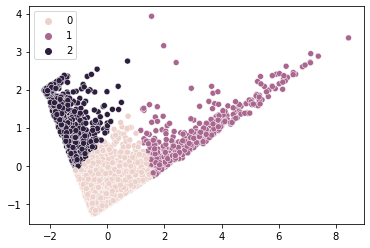

In [48]:
sns.scatterplot(x=pca_rfm.T[0], y=pca_rfm.T[1], hue=kmeans.labels_)

### DBSCAN

- Сначала мы случайным образом инициализируем k точек.
- Мы классифицируем каждый элемент по ближайшему среднему значению и обновляем координаты среднего значения, которые представляют собой средние значения элементов, отнесенных к этому среднему значению на данный момент.
- Мы повторяем процесс для заданного количества итераций, и в конце получаем группы кластеров.

In [49]:
dbscan = DBSCAN(min_samples=7, metric='euclidean')
dbscan.fit(rfm_df_scaled)

DBSCAN(min_samples=7)

In [50]:
dbscan.labels_

array([ 0,  0,  0, ...,  0, -1,  0], dtype=int64)

In [51]:
rfm['ClusterID_DBSCAN'] = dbscan.labels_
rfm.head()

,CustomerID,Recency,Frequency,Monetary,ClusterID,ClusterID_DBSCAN
1,12347.0,1,182,4310.00,1,0
2,12348.0,74,31,1797.24,0,0
3,12349.0,18,73,1757.55,0,0
4,12350.0,309,17,334.40,2,0
5,12352.0,35,85,2506.04,0,0


#### Визуализация кластеров (DBSCAN)

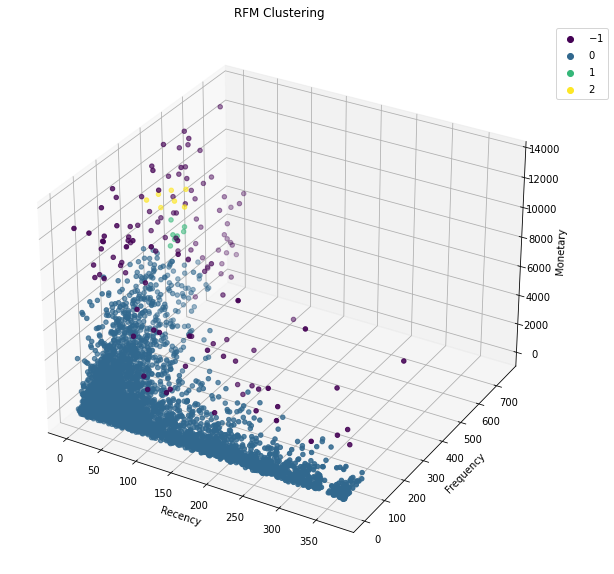

In [52]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(xs=rfm['Recency'], ys=rfm['Frequency'], zs=rfm['Monetary'], c=rfm['ClusterID_DBSCAN'])

plt.title('RFM Clustering')
ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')
plt.legend(*sc.legend_elements(), bbox_to_anchor=(1,1), loc=2)

#### C понижением размерности до 2D

In [53]:
pca = PCA(n_components = 2)
pca_rfm = pca.fit_transform(rfm_df_scaled.to_numpy())

<AxesSubplot:>

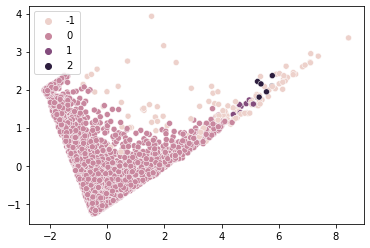

In [54]:
sns.scatterplot(x=pca_rfm.T[0], y=pca_rfm.T[1], hue=dbscan.labels_)

### Иерархическая кластеризация

#### Агломеративная иерархическая кластеризация

In [55]:
rfm_df.head()

,Recency,Frequency,Monetary
1,1,182,4310.00
2,74,31,1797.24
3,18,73,1757.55
4,309,17,334.40
5,35,85,2506.04


In [56]:
agg_clustering = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
agg_clustering.fit(rfm_df)

AgglomerativeClustering(distance_threshold=0, n_clusters=None)

In [57]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)
    dendrogram(linkage_matrix, **kwargs)

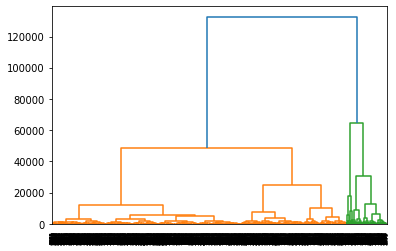

In [58]:
plot_dendrogram(agg_clustering)

## Результат

K-Means Clustering
* Кластер 0 - разовые, нечастые клиенты.
    - Они составляют подавляющее большинство клиентов (83%), но приносят лишь немногим более 40% от общего дохода. Их сумма транзакции по счету довольно низкая - 13 долларов.
    - В среднем они последний раз совершали покупки в Интернете около 102 дней назад.
    - Они совершают покупки лишь изредка, поскольку в течение исследуемого периода типичный покупатель класса 0 размещает в общей сложности около 50 заказов.
* Кластер 1 - обычные клиенты
    - Они составляют около 14% всех клиентов и второй по величине источник дохода (40%).
    - Средняя давность около 30 дней назад.
    - Они часто делают покупки, в среднем 210 заказов на человека.
* Кластер 2 - частые, ценные клиенты / оптовики.
    - Есть только 93 клиента кластера 2, которые составляют всего 2% от общего числа клиентов и 9% от общего числа транзакций, но более 18% общего дохода поступает от них.
    - Они также любят делать покупки и в целом тратят гораздо больше. Их средняя сумма покупки за транзакцию составляет около 36 долларов, что является самым высоким показателем среди всех трех групп клиентов. Их средняя общая сумма расходов составляет более 11 500 долларов.
    - Они покупают довольно часто со средней давностью 17 дней. Они делают покупки почти каждый день: в среднем покупатель класса 2 совершает покупки 321 раз за последний год.